# Clustering with PCA [40 points]

In this applied question, you are asked to use Principal Component Analysis (PCA) for dimensionality reduction and then apply K-means clustering and Gaussian Mixture Model (GMM). You will use handwritten dataset from sklearn library.

Let's start by loading the data:

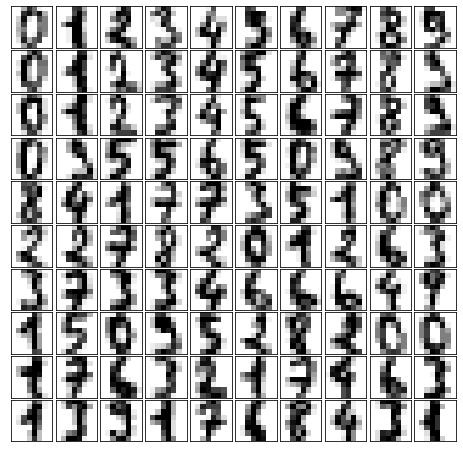

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

## PCA (15 points)

To gain intuition on the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [2]:
# Import PCA
from sklearn.decomposition import PCA

## project from 64 to 2 dimensions using PCA
pca = PCA(n_components=2)
pca.fit_transform(digits.data)
comp = pca.components_
com_tr = np.transpose(pca.components_)
projected = np.dot(digits.data,com_tr)

print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


### Visualize the projected data

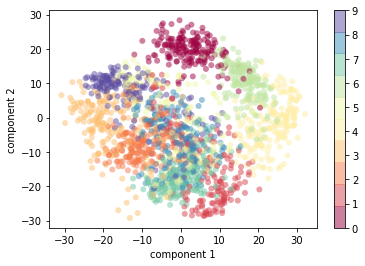

In [3]:
## visualize projected data using scatter plot
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**Question:** Based on the scatter plot using first two principal components, can K-means clustering perfectly separate all the classes when only 2 principal components are used? Explain why in 1-2 sentences.

***No.  Visually there is not clear decision boundary to separate the features on.  Thus, k-means will be extremely sensitive to the inital positions of the centroids.***

### Choosing the number of components

To decide the number of components to keep, let's look at the cumulative explained variance ratio as a function of the number of components.

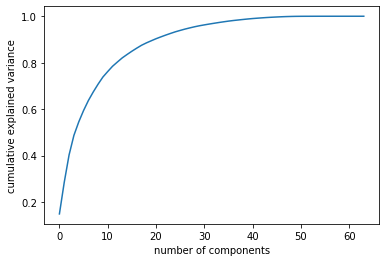

In [24]:
## obtain all the components and plot the cumulatie explained variance with respect to the number of components
pca = PCA().fit(digits.data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

**Question:** How many components are needed to contain approximately 90% of the variance? And how many to describe close to 100% of the variance?

***Based on the graph, we need aproximately 20 to 25 components to keep 90% of the variance and aproximately 40 components to keep 100% of the varaince***

Use the number of components to keep approximately 90% of the variance to reduce the dimension of the our data.

In [4]:
pca = PCA(n_components=20)
pca.fit_transform(digits.data)
comp = pca.components_
com_tr = np.transpose(pca.components_)
projected = np.dot(digits.data,com_tr)

print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 20)


## K-means Clustering (10 points)

Let's use K-means clustering algorithm to group the data points into 10 different clusters:

In [12]:
from sklearn.cluster import KMeans

## Initiate and fit a K-means model to projected data
kmeans = KMeans(n_clusters=10, random_state = 0)
kmeans.fit(projected)
clusters = kmeans.predict(projected)

kmeans.cluster_centers_.shape

(10, 20)

The cluster centers themselves are 10-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's **un-project** these cluster centers back to the original 64 dimensions using inverse_transform of PCA and see what these cluster centers look like:

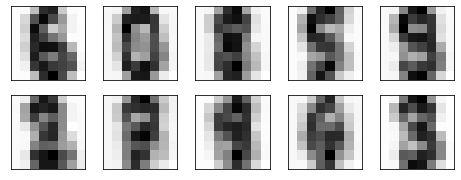

In [13]:
## unproject the cluster centers in reduced dimension back to original dimension. Hint: use inverse_transform in PCA
cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Can you visually label each of these un-projected cluster centers? If yes, please give a digit label for each of the cluster centers?

***Some numbers are easy to distinguish while others are not.  Numbers which are easily seen are shown below***

    6 0 8 5 x 
    x x x x 3


    

By default, the number of times the K-means algorithm will be run with different centroid **seeds** is 10. The final result will be the best output of n_init consecutive runs in terms of inertia. Let's increase this number to 100 and compare the results.

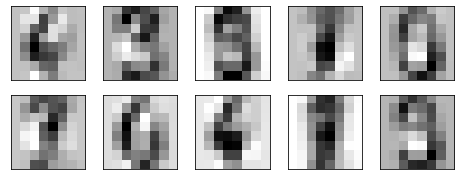

In [32]:
kmeans = KMeans(n_clusters=10, n_init = 100, random_state = 0)
kmeans.fit(projected)
clusters = kmeans.predict(projected)

cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = cluster_centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

**Question:** Do the cluster centers look similar or different from those returned using only 10 runs?

***Visually, the outputs look somewhat different. Some appear to be the same, such as the 8, while others look different but more easily understood visually. ***

### Measure accuracy of K-means clustering

Because K-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them.

In [15]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7941012799109627

## Compare K-means and Gaussian Mixture Models (Expectation Maximization) (10 points)

For visualization purposes, let's use first two principal components only in the PCA and compare the results of K-means and GMM.

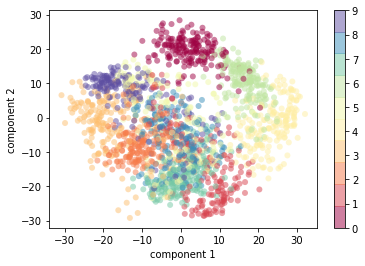

In [25]:
pca = PCA(n_components=2, random_state = 0)
pca.fit_transform(digits.data)
comp = pca.components_
com_tr = np.transpose(pca.components_)
projected = np.dot(digits.data,com_tr)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


0.6060100166944908

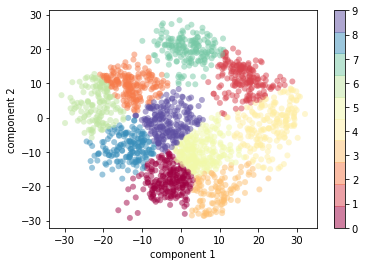

In [26]:
## train a K-means model on projected data, plots the clusters and measure the accuracy
kmeans = KMeans(n_clusters=10, n_init = 100, random_state = 0)
kmeans.fit(projected)
clusters = kmeans.predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

0.5848636616583194

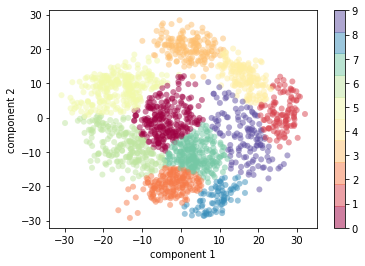

In [28]:
## train and plot GMM

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state = 0)
gmm.fit(projected)
clusters = gmm.predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=clusters, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

**Question:** Compare the accuracy of K-means and GMM? Can you spot the differences that explain the comparison results in the plots of K-means and GMM clusters?


***K-means achieved 60% accuracy and GMM achieved 58% accuracy.  The data seems to be clustered and labeled differently across the two models.  Since both models are sensitive to the initialization of their centroids, and the true data is not linearly separable after applying PCA with n=2, it makes sense that they will sometimes classify the data differently for a given iteration. ***

## t-SNE for dimensionality reduction (5 points)

Let's try t-SNE to reduce the original data dimension to 2 and then use K-means to cluster it.

0.9348914858096828

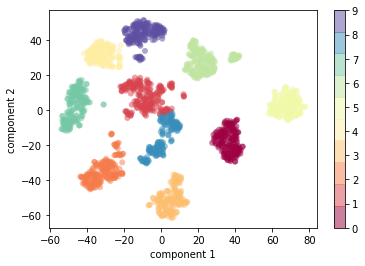

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
projected = tsne.fit_transform(digits.data)

kmeans = KMeans(n_clusters=10, n_init = 100)
kmeans.fit(projected)
clusters = kmeans.predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

**Question:** Compare the accuracy resulted from K-means with t-SNE (n_components = 2) with that of K-means with PCA (n_components = 20) and justify your observation (why)?

***Our PCA was not able to acurately capture the underlying trends compared to the t-SNE.  This can be clearly seen in the accuracy of our k-means model when working with the data reduced by PCA vs the data reduced by t-SNE.  The accurrcy of the k-means using PCA n = 20 was 79% while the accuracy of k-means using t-SNE with n=2 was 94%.  In t-SNE, similarities are defined probabilistically, while in PCA similarities are defined along the lines that maximize variance.  Furthermore, t-SNE can capture non-linear trends in the data, while PCA can only capture linear trends in the data.  t-SNE will not be able to be applied to new data, as it is transductive.***